# Visualization of Volatility Surface Strcutures
This notebook shows how to use Multi Dimnsional Scaling (MDS) to visualize the distance between the Dax constituents Volatility Surfaces. To use the data outside the notebooks context, please ask frontmark for permission.

[<img style="float: left;" src="images/favicon_2.png" width="40">](http://frontmark.de) 

In [17]:
import pandas as pd
import datetime as dt
import numpy as np
from scipy.interpolate import interp1d

#to beautify the plots, you may use seaborn by uncommenting the following two lines
#import seaborn as sns
#sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

## Helper Functions

In [2]:
def read_data(file = './data/vols_DAX.zip'):
    """  Lese das csv Fiel mit den Daten ein 
    """
    vols = pd.read_csv(file)
   
    return vols

def preprocess_data(vols):
    """ Normalisiere die Daten (ziehe 1YR ATM-IV von den anderen Vols ab) und lösche alle Spalten, die keine Vols enthalten.
    """
    vol_columns = [x for x in vols.columns if 'IV' in x]
    vols_normalized = vols[vol_columns].subtract(vols['IV_365_1.0'], axis=0)
    vols_normalized.drop(['IV_365_1.0'], axis=1, inplace=True)
    return vols_normalized

def plot_embedding(Y, vols, ref_vol_column = 'IV_1.0_365', annotate=None):
    """ Plotte die niederdimensionale Einbettung der Punkte als Scatterplot.
        Y: Punkte, die geplottet werden sollen
        vols: Das zugehörige DataFrame um den Plot mit Informationen anzureichern (bspw. Name der Underlyings)
        annotate: Liste der Uderlying-Namen, die in dem Plot bezeichnet werden sollen
    """
    def point_size(vols, column = 'IV_1.0_365'):
        max_vol = max(vols[column])
        min_vol = min(vols[column])
        scaler = [ (50.0*(max_vol-vol) + 800.0*(vol-min_vol))/(max_vol-min_vol) for vol in vols[column]]
        return scaler
    
    # buildup edge color depending on index and share
    edgecolor_index = 'b'
    edgecolor_share = 'r'
    edgecolors = []
    markers = []
    for i in range(vols.shape[0]):
        if vols['type'].iloc[i] == 'Share':
            edgecolors.append(edgecolor_share)
            markers.append('o')
        else:
            edgecolors.append(edgecolor_index)
            markers.append('s')
    
    plt.scatter(Y[:, 0], Y[:, 1], s = point_size(vols,'IV_365_1.0'), c=vols['IV_365_1.0'], cmap='brg', alpha=0.5, edgecolor=edgecolors,
               linewidths=2, marker = 'o')#'k')
    plt.colorbar()
    for i in range(Y.shape[0]):
        if annotate is None or vols.index[i] in annotate:
            plt.annotate(vols['shortname'].iloc[i], (Y[i,0], Y[i,1]))

## Read Volatility Data

In [4]:
vols = read_data(file = './data/vols_DAX.zip')
print('The following underlyings are contained in the dataset: \n' + '\n'.join(vols['shortname'].unique()))

The following underlyings are contained in the dataset: 
adidas
Allianz
BASF
Bayer
Beiersdorf
BMW_St_
Continental
Covestro
Daimler
Dt__Bank
Dt__Boerse
Dt__Post
Dt__Telekom
E_ON
Fresenius_St_
FMC
Heidelbg_Cement
Henkel_Vz_
Infineon
Linde
Lufthansa
Merck
MTU
Muenchener_Rueck
RWE_St_
SAP
Siemens
VW_St_
Vonovia
Wirecard
DAX


In [5]:
# Uncomment the following lines to get timepoints where volatilities are available
#vols.refdate.unique()
refdate = '2020-01-22'
input_vols = vols[vols['refdate']==refdate]
input_vols_normalized = preprocess_data(input_vols)

## MDS

We are interested to analyze the interdependence of the dfferent volatility surfaces. To be more precise, we would like to visualize the 'distance' between surfaces for all constituents in the DAX. As a distance measure between two volatility surfaces we just take the euclidean distance between certain volatility points on the surfaces. Here, one may come up with other ideas, but to keep simple we restrict on this approach. To get rid of the effect of the volatility level on the distance we normalize the data by subtracting the 1 year at the money volatility from all volatility points of the surface. 

Now, we can apply MDS to get a two-dimensional embedding of the data, that tries to reproduce the distances between the volatilities as the euclidean distance between the two dimensional points.

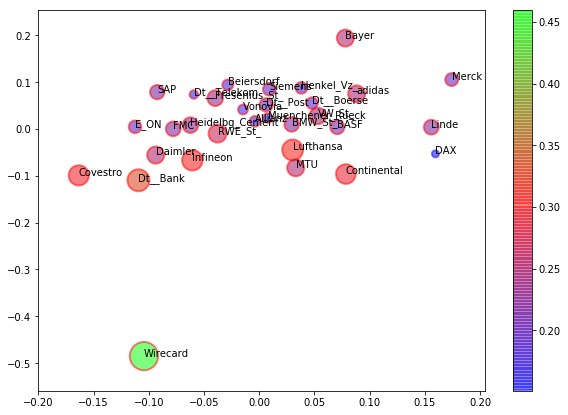

In [6]:
from sklearn.manifold import MDS

Y = None
n_init=40

mds = MDS(n_components=2, metric=True, n_init=n_init, max_iter=600,  eps=0.001, random_state=42, dissimilarity='euclidean')
Y = mds.fit_transform(input_vols_normalized, init = Y)
fig=plt.figure(figsize=(10, 7))
plot_embedding(Y, input_vols, )

### Varying parameters

One should always check if the results are reliable in the sense that they are stable and robust w.r.t. changes of the training and model parameters. To illustrate this, we test the algorithm for a different number of iterations (to see if it converged) as well as a different of initialization steps. Note that the problem itself has no unique solution, e.g. all rotations of a solution will keep the distances between the points constant ans so all rotations lead to a new solution of the problem.

**Number of Iterations**

In [8]:
Y = [None]*4
n_iter = [10, 100, 500, 1000]
for i in range(4):
    Y[i] = MDS(n_components=2, metric=True, n_init=10, max_iter=n_iter[i],  eps=0.001, 
               random_state=42, dissimilarity='euclidean').fit_transform(input_vols_normalized, init = None)

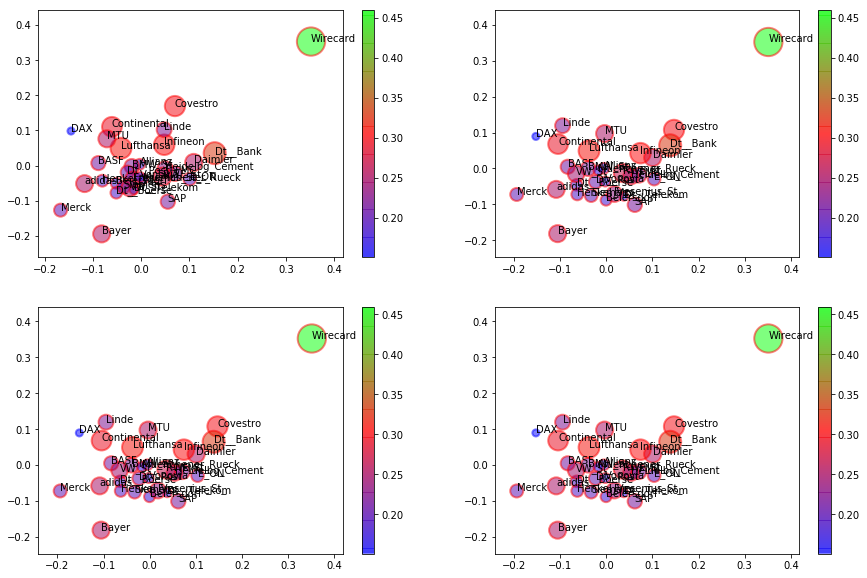

In [9]:
# plotte die Ergebnisse für die unterschidlichen Parameter
fig=plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plot_embedding(Y[0], input_vols)
plt.subplot(2,2,2)
plot_embedding(Y[1], input_vols)
plt.subplot(2,2,3)
plot_embedding(Y[2], input_vols)
plt.subplot(2,2,4)
plot_embedding(Y[3], input_vols)

**Number Initialization Steps**

In [10]:
Y = [None]*4
n_init = [10, 100, 200, 300]
for i in range(4):
    Y[i] = MDS(n_components=2, metric=True, n_init=10, max_iter=1000,  eps=0.001, 
               random_state=42, dissimilarity='euclidean').fit_transform(input_vols_normalized, init = None)

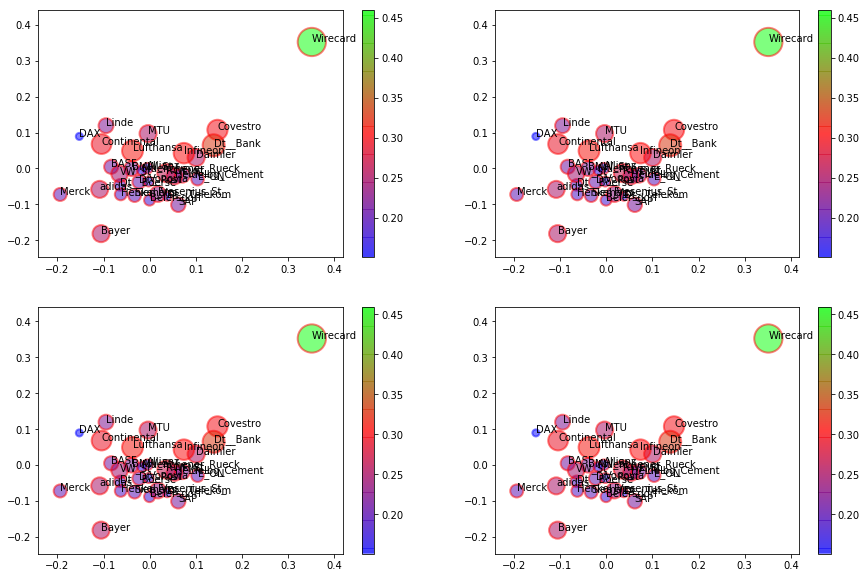

In [11]:
# plotte die Ergebnisse für die unterschidlichen Parameter
fig=plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plot_embedding(Y[0], input_vols)
plt.subplot(2,2,2)
plot_embedding(Y[1], input_vols)
plt.subplot(2,2,3)
plot_embedding(Y[2], input_vols)
plt.subplot(2,2,4)
plot_embedding(Y[3], input_vols)

## Create Animation

This section contains code to generate a sequence of images from the time series of volatilities. The sequence of generated images can then be used to create an animation (for example by using [imagemagick](https://imagemagick.org/index.php)). The results may be look like shown in the figure below.
<img src="images/vol_movie_mds.gif", width="600">

This animated GIF has been created with imagemagick by:

>> magick convert -delay 20 fig_*.png -loop 0 vol_movie_mds.gif

using the generated images from the code below.

## Helper function

In [16]:
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances

def get_embedding(Y, vols, t, x_lim, y_lim, file = None, ref_vol_column = 'IV_1.0_365',title=None, annotate=None):
    def point_size(vols, column = 'IV_365_1.0'):
        max_vol = 1.0 #max(vols[column])
        min_vol = 0.1 #min(vols[column])
        scaler = [ (50.0*(max_vol-vol) + 1000.0*(vol-min_vol))/(max_vol-min_vol) for vol in vols[column]]
        return scaler
    
    edgecolor_index = 'b'
    edgecolor_share = 'r'
    edgecolors = []
    markers = []

    for i in range(vols.shape[0]):
        if vols['type'].iloc[i] == 'Share':
            edgecolors.append(edgecolor_share)
            markers.append('o')
        else:
            edgecolors.append(edgecolor_index)
            markers.append('s')
    fig = plt.figure(figsize=(15,10))
    plt.scatter(Y[:, 0], Y[:, 1], s = point_size(vols,'IV_365_1.0'), c=vols['IV_365_1.0'], cmap='brg', alpha=0.5, #edgecolor=edgecolors,
               linewidths=2, marker = 'o')#'k')
    plt.clim(0.15,0.6)
    plt.colorbar()
    
    vol_limit = vols['IV_365_1.0'].quantile(0.85)
    for i in range(Y.shape[0]):
        if annotate is None or vols.index[i] in annotate:
            if vols['shortname'].iloc[i] == 'DAX' or vols['shortname'].iloc[i] == 'Wirecard':
                plt.annotate(name_map[vols['shortname'].iloc[i]], (Y[i,0], Y[i,1]), fontsize=20, fontweight='bold')
    annotation = np.argsort(sklearn.metrics.euclidean_distances(Y).sum(axis=1))
    for i in range(7):
        index = annotation[-i]
        if vols['shortname'].iloc[index] != 'DAX' and vols['shortname'].iloc[index] != 'Wirecard':
            #elif vols['IV_365_1.0'].iloc[i]> vol_limit:
            plt.annotate(name_map[vols['shortname'].iloc[index]], (Y[index,0], Y[index,1]), fontsize=15, fontweight='bold')
  
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    if title is not None:
        plt.title(title, fontsize=20, fontweight='bold')
    img = mpimg.imread('images/favicon_2.png')
    #im = fig.figimage(img,  xo=0, yo=0, origin='lower')#)#fig.bbox.ymax - height)
    ax = plt.axes([0.15,0.15, 0.1, 0.1], frameon=True)  # Change the numbers in this array to position your image [left, bottom, width, height])
    ax.imshow(img)
    ax.set_axis_off()
    if file is not None:
        plt.savefig(file)
        plt.close(fig)

In [14]:
# Comment the following line to make the image creation working. This is here to prevent an accidential creation and storage of a huge bunch of pictures.
raise Exception('This is a warning that the following code cells may produce many last line of defence')

# first compute sequence of MDS
vols = read_data(file = './data/vols_DAX_earlier.csv')
dates = [x for x in vols.refdate.unique()]
dates.sort()

Y = []
n_init = 30
n_udls = len(vols['shortname'].unique())

dates_new = []
for refdate in dates:
    mds = MDS(n_components=2, metric=True, n_init=n_init, max_iter=600,  eps=0.001, random_state=42, dissimilarity='euclidean')
    input_vols = vols[vols['refdate']==refdate].sort_values('shortname', axis=0)
    if input_vols.shape[0] != n_udls:
        print('Skipping ' + str(refdate) + ' since some underlying vol is missing.')
        continue
    dates_new.append(refdate)
    input_vols_normalized = preprocess_data(input_vols)
    if len(Y) > 0:
        init = Y[-1]
    else:
        init=None
    Y.append( mds.fit_transform(input_vols_normalized, init = init))
    n_init = 1
    

Exception: This is a warning that the following code cells may produce many last line of defence

## Create Image Sequence

In [15]:
image_dir = 'C:\\temp\\test' # please specify your directory to write the images here

x = np.arange(len(Y))
f = interp1d(x, Y, axis=0)

# get maximum x and y values to hold all axes limits between the imges fix
max_x = max([max(x[:,0]) for x in Y])
min_x = min([min(x[:,0]) for x in Y])
max_y = max([max(y[:,1]) for y in Y])
min_y = min([min(y[:,1]) for y in Y])

month_map = {'01': 'Jan',
            '02': 'Feb',
            '03': 'Mar',
            '04': 'Apr',
            '05': 'Mai',
            '06': 'Jun',
            '07': 'Jul',
            '08': 'Aug',
            '09': 'Sep',
            '10': 'Oct',
            '11': 'Nov',
            '12' : 'Dec'}
# Due to tecnical reasons some names are a little cryptical and we define thie following maping to get rid of this :-) and get nice names
name_map = {k:k for k in vols['shortname'].unique()} 
name_map['BMW_St_'] = 'BMW'
name_map['Dt__Bank'] = 'Deutsche Bank'
name_map['Dt__Boerse'] = 'Deutsche Börse'
name_map['Dt__Post'] = 'Deutsche Post'
name_map['Dt__Telekom'] = 'Deutsche Telekom'
name_map['E_ON'] = 'EON'
name_map['Fresenius_St_'] = 'Fresenius'
name_map['Heidelbg_Cement'] = 'Heidelberg Zement'
name_map['Henkel_Vz_'] = 'Henkel'
name_map['RWE_St_'] = 'RWE'
name_map['VW_St_'] = 'VW'

ims = []
n_steps = 4
dates_long = []
for d in dates_new:
    for i in range(n_steps):
        dates_long.append(d)
for i in range(n_steps*len(Y)-1):
    tmp = dates_long[i].split('-')
    title = month_map[tmp[1]] + ' ' + tmp[0]
    t = float(i)/float(n_steps)
    input_vols = vols[vols['refdate']==dates_long[i]].sort_values('shortname', axis=0)
    im = get_embedding(f(t), input_vols, i, (min_x, max_x,), (min_y, max_y,), title = title, 
                       file=image_dir+'\\fig_'+format(i, '03d')+'.png'
                      )
    #break


NameError: name 'np' is not defined